In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ccnlab/Development/dl4rl/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tqdm

from sequence_generator import create_stim_sequence
from concurrent.futures import ProcessPoolExecutor
from sim_agent import simulate_agent, simulate_mixture_agent
from utils.simulate_utils import generate_beta_with_diff_means_sim_vars


In [2]:
pval = 1
num_blocks = 12

num_stimuli_list = [2, 6]
min_switches = [1200, 1200]
iter_per_stimuli = 13
num_actions = 3

half_block_no = int(num_blocks / 2)
conditions = [0] * half_block_no + [1] * half_block_no
random.shuffle(conditions)
all_seq = []
for i in range(num_blocks):
    num_stim = num_stimuli_list[conditions[i]]
    all_seq.append(create_stim_sequence(iter_per_stimuli, num_stim))

0.3359375 1.0078125


Text(0.5, 0, 'alpha')

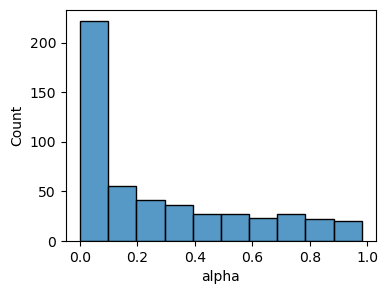

In [ ]:
eps_dist, _, a, b, _, _ = generate_beta_with_diff_means_sim_vars(
     0.25, 0.55, 0.08, 500, 0, 1
)
print(a, b)
fig = plt.figure(figsize=(4, 3))
ax = sns.histplot(eps_dist, bins=20)
ax.set_xlabel('alpha')

## Simulate mixture model

In [149]:
N_AGENTS = 10000
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
    mean1, mean1, var, N_AGENTS, 0, 0.4
)
# 0.05
eps_dist, bias_dist, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
     0.1, 0.4, 0.01, N_AGENTS, 0, 1
)

eta2_wm_dist, eta6_wm_dist, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
     0.8, 0.6, 0.01, N_AGENTS, 0, 1
)
alpha_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
     0.25, 0.55, 0.08, N_AGENTS, 0, 1
)

#sticky_dist = np.random.uniform(-0.02, 0.02, N_AGENTS)
sticky_dist = np.random.uniform(-0.2, 0.2, N_AGENTS)
bias_dist = np.random.uniform(0, 1, N_AGENTS)

In [150]:
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = [
        executor.submit(
            simulate_mixture_agent,
            a,
            num_blocks,
            conditions,
            iter_per_stimuli,
            num_actions,
            all_seq,
            using_rl=False,
            params_dist={
                "alpha": alpha_dist[a],
                "eta2_wm": eta2_wm_dist[a],
                "eta6_wm": eta6_wm_dist[a],
                "phi": phi_dist[a],
                "stickiness": sticky_dist[a],
                "bias": bias_dist[a],
                "eps": eps_dist[a],
            },
        )
        for a in range(N_AGENTS)
    ]
    train_data_list = [future.result() for future in tqdm.tqdm(futures)]

train_df = pd.concat(train_data_list)

100%|██████████| 10000/10000 [02:10<00:00, 76.62it/s]


## Simulate single model

In [ ]:
# Prepare the sequences

N_AGENTS = 9000
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
    mean1, mean1, var, N_AGENTS, 0, 0.4
)
# 0.05
eps_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(
     0.1, 0.1, 0.01, N_AGENTS, 0, 1
)
alpha_dist = np.random.uniform(0.2, 0.8, N_AGENTS)
sticky_dist = np.random.uniform(-0.2, 0.2, N_AGENTS)
beta_dist = np.random.uniform(0.2, 0.8, N_AGENTS)
bias_dist = np.random.uniform(0, 1, N_AGENTS)
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = [
        executor.submit(
            simulate_agent,
            a,
            pval,
            num_blocks,
            num_stimuli_list,
            min_switches,
            iter_per_stimuli,
            num_actions,
            all_seq,
            params_dist={
                "alpha": 1,
                "phi": phi_dist[a],
                "stickiness": sticky_dist[a],
                "bias": bias_dist[a],
                "eps": eps_dist[a],
                "beta": 1.25, #beta_dist[a],
            },
        )
        for a in range(N_AGENTS)
    ]
    train_data_list = [future.result() for future in tqdm.tqdm(futures)]

train_df = pd.concat(train_data_list)
train_df.head(3)

In [ ]:
# train_df = train_df.drop('delay_since_last_correct_cat', axis=1)
# train_df.columns

## Save the data

In [151]:
from utils.feature_utils import get_iter_acc_without_switches

max_num_trials = train_df.trials.max() + 1
filename = f"../data/wmh_26s3a/{N_AGENTS}a_{num_blocks}b_{max_num_trials}t_wmh_no_switch_uni_bias.csv"
print(filename)

iter_acc = get_iter_acc_without_switches(train_df)
train_df['stim_iter'] = iter_acc['stim_iter'].to_list()

../data/wmh_26s3a/10000a_12b_78t_wmh_no_switch_uni_bias.csv


In [152]:
train_df.to_csv(filename)

## Eval

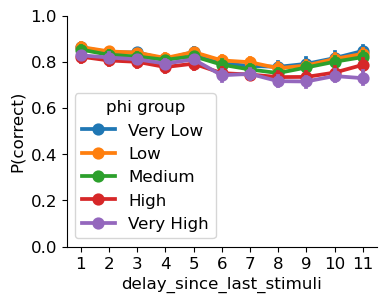

In [129]:
res = train_df[train_df.delay_since_last_stimuli > 0].copy()
# Create 5 equal-width bins for bias values
res['phi group'] = pd.qcut(res['phi'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
res = (
    res.groupby(["agentid", "delay_since_last_stimuli", "phi group"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_stimuli",
    y="rewards",
    hue="phi group",
    ax=ax,
)
ax.set_xlabel("delay_since_last_stimuli")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()

In [130]:
from utils.feature_utils import get_iter_acc_without_switches

iter_acc = get_iter_acc_without_switches(train_df)
iter_acc.head(2)

,stim_iter,stimuli,rewards,condition,actions,trials,agentid,block_no
0,1,0,0,1,2,0,0,0
1,1,1,0,1,1,1,0,0


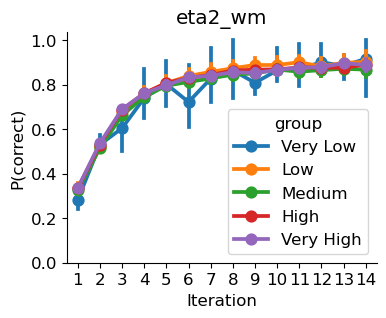

In [131]:
key = 'eta2_wm'
iter_acc[key] = train_df[key].tolist()

# Create 5 equal-width bins for bias values
#iter_acc['group'] = pd.qcut(iter_acc[key], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
iter_acc['group'] = pd.cut(iter_acc[key], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
# Group by bias group and calculate mean rewards
bias_group_stats = iter_acc.groupby(["agentid",  'stim_iter', 'group'])['rewards'].mean().reset_index()

# Plot the results
plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.pointplot(
    data=bias_group_stats,
    x="stim_iter",
    y="rewards",
    hue="group",
    ax=ax,
)
ax.set_title(key)
ax.set_xlabel("Iteration")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))
sns.despine()


<Axes: xlabel='group', ylabel='eta2_wm'>

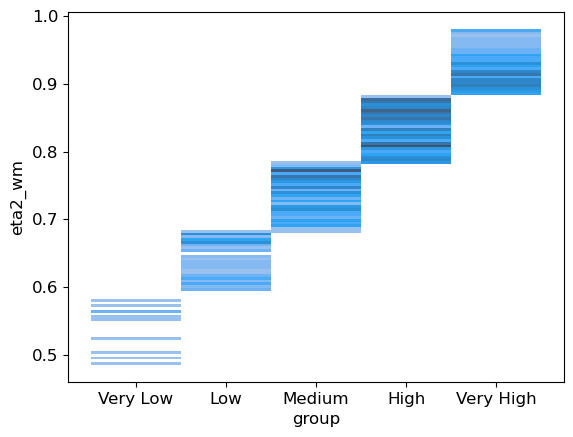

In [105]:
sns.histplot(data=iter_acc, x='group', y=key)

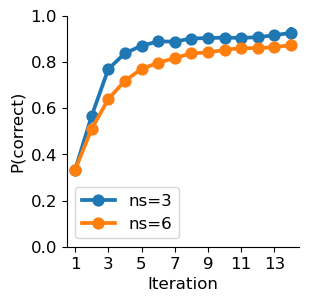

In [132]:
res = (
    iter_acc.groupby(["agentid", "stim_iter", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="stim_iter",
    y="rewards",
    hue="condition",
    ax=ax,
)
ax.set_xlabel("Iteration")
ax.set_ylabel("P(correct)")
# Change legend labels
handles, labels = ax.get_legend_handles_labels()
labels = ['ns=3', 'ns=6']
ax.legend(handles, labels)

# ax.hlines(0.33, xmin=0, xmax=18, color='red')
max_num_iter = res.stim_iter.max()
ax.set_xticks(np.round(np.arange(0, max_num_iter, 2), 2))
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

# fig.tight_layout(rect=[0, 0, 1, 0.95])

sns.despine()

In [138]:
def get_error_counts_by_trial(stimuli, actions, rewards):
    error_map = {}
    all_chosen_errors, all_unchosen_error = [], []
    chosen_error, unchosen_error = 0, 0 
    for s, a, r in zip(stimuli, actions, rewards):
        if r == 0:
            error_map, chosen_error, unchosen_error = update_error_count_with_slow_response(s, a, error_map)
            # # skip the error pair [0, 0],
            # # which means that the stimuli is first encountered in the error trials.
            # if chosen_error == 0 and unchosen_error == 0:
            # continue

        all_chosen_errors.append(chosen_error)
        all_unchosen_error.append(unchosen_error)

    return all_chosen_errors, all_unchosen_error

def update_error_count_with_slow_response(stim, action, stimuli_action_error_count):
    a = action
    chosen_error, unchosen_error = 0, 0
    # slow responses
    if a == -1:
        if stim in stimuli_action_error_count:
            errors = list(stimuli_action_error_count[stim].values())
            unchosen_error = np.sum(errors)
        return stimuli_action_error_count, 0, unchosen_error
    # first time encounter stimuli in error trials.
    # chosen and unchosen will be 0, 0 since no pervious errors for this stimuli.
    if stim not in stimuli_action_error_count:
        stimuli_action_error_count[stim] = {a: 0}
    # new action and stimuli pair error
    elif a not in stimuli_action_error_count[stim]:
        errors = list(stimuli_action_error_count[stim].values())
        unchosen_error = np.sum(errors)
        # initialize the map
        stimuli_action_error_count[stim][a] = 0
    # stimuli and action has been chosen before
    else:
        # unchosen errors are errors from other actions
        errors = [
            v if k != a else 0 for k, v in stimuli_action_error_count[stim].items()
        ]
        unchosen_error = np.sum(errors)
        # chosen errors are errors from the same action in previous trial
        chosen_error = stimuli_action_error_count[stim][a]

    # increment the error for the current error trial
    stimuli_action_error_count[stim][a] += 1
    return stimuli_action_error_count, chosen_error, unchosen_error

def get_error_res(all_data):
    result_dfs = []
    for (agent_id, block_no), block_data in all_data.groupby(['agentid', 'block_no']):
        # Reset index for consistent processing
        block_data = block_data.reset_index(drop=True)    
        chosen_error, unchosen_error = [], []
        incorrect_data = block_data[(block_data.rewards == 0)]

        # error count until trial t-1
        error_counts = get_error_counts_by_trial(
            block_data.stimuli, block_data.actions, block_data.rewards
        )
        chosen_error.extend(error_counts[0])
        unchosen_error.extend(error_counts[1])
        res = {
            "id": block_data.agentid.tolist(),
            "block_no": block_data.block_no.tolist(),
            "trials": block_data.trials.tolist(),
            "condition": block_data.condition.tolist(),
            "set_size": block_data.set_size.tolist(),
            "chosen_error": chosen_error,
            "unchosen_error": unchosen_error,
        }
        result_dfs.append(pd.DataFrame(res))

    return pd.concat(result_dfs, ignore_index=True)

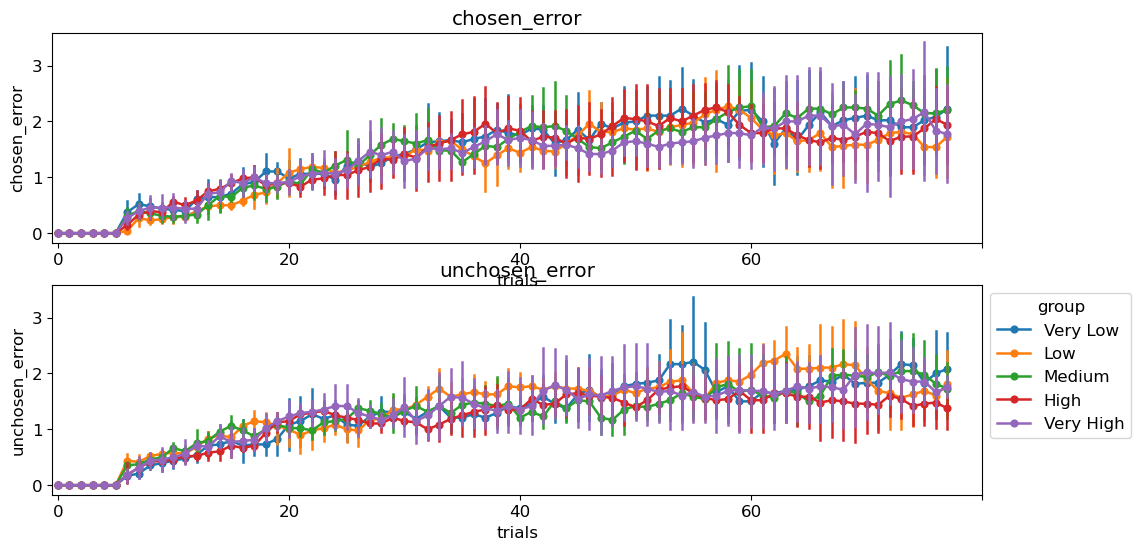

In [186]:
error_res = get_error_res(train_df)
error_res['stim_iter'] = iter_acc['stim_iter']
key = 'alpha'
error_res[key] = train_df[key].tolist()

# Create 5 equal-width bins for bias values
error_res['group'] = pd.qcut(error_res[key], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
res = error_res.groupby(["id", "trials", "group"])[["chosen_error", "unchosen_error"]].mean().reset_index()
res = res.dropna(subset=['chosen_error'])

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
for i, yp in enumerate(['chosen_error', 'unchosen_error']):
    showlegend = i == 1
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 4
    sns.pointplot(
        data=res,
        x="trials",
        y=yp,
        hue="group",
        ax=axes[i],
        legend=showlegend,
    )
    axes[i].set_title(yp)
    axes[i].set_xticks(np.round(np.arange(0, 100, 20), 2))
    #axes[i].set_xticks(np.round(np.arange(0, 13, 2), 2))
    if showlegend:
        sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df["delay_since_last_correct_cat"] = train_df["delay_since_last_correct"].apply(
    lambda x: "2+" if x > 2 else str(x)
)
# train_df[['stimuli', 'trials', 'rewards', 'delay_since_last_correct']].tail(10)
res = train_df[train_df.delay_since_last_correct > 0]
res = (
    res.groupby(["agentid", "delay_since_last_correct_cat", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_correct_cat",
    y="rewards",
    order=["1", "2", "2+"],
    hue="condition",
    ax=ax,
    ci=95,
)
ax.set_xlabel("delay_since_last_correct")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()